## Experimento 1: Transporte determinista (Advección pura)

**Observación visual:**
Al simular las partículas usando solo el vector de viento constante, observamos que todas se mueven formando una línea recta o un punto denso que se desplaza.

**Explicación física:**
En esta etapa, el modelo es puramente **determinista**.
$$\vec{r}_{nuevo} = \vec{r}_{viejo} + \vec{V}_{viento} \cdot dt$$

Como todas las partículas nacen en el mismo punto $(0,0)$ y experimentan exactamente la misma velocidad de viento, no existe ninguna fuerza que las separe entre sí. Matemáticamente, la varianza de la posición es cero. Esto representa un flujo laminar ideal sin turbulencia, lo cual no es realista para una nube volcánica.

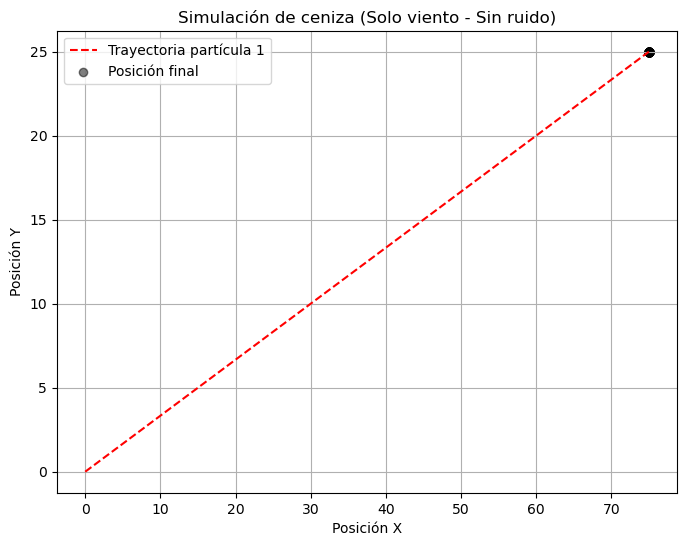

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# CONFIGURACIÓN
N_PARTICULAS = 100
DT = 1.0          # Paso de tiempo
TIEMPO_TOTAL = 50 # Pasos totales

# Array de posiciones, todas empiezan en (0,0)
posiciones = np.zeros((N_PARTICULAS, 2))

# Definir viento (velocidad constante en x, y)
viento = np.array([1.5, 0.5]) 

# Guardamos la posición de todas las partículas en cada paso
historial = [posiciones.copy()]

# BUCLE DE SIMULACIÓN 
for t in range(TIEMPO_TOTAL):
    # Mover partículas
    posiciones = posiciones + (viento * DT)
    historial.append(posiciones.copy())

# VISUALIZACIÓN 

historial = np.array(historial)

plt.figure(figsize=(8,6))

# Graficar la trayectoria de la primera partícula como ejemplo
plt.plot(historial[:, 0, 0], historial[:, 0, 1], 'r--', label='Trayectoria partícula 1')

# Graficar la posición final de todas las partículas( Como no hay ruido aleatorio aun, todas estarán en el mismo punto)
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], alpha=0.5, c='black', label='Posición final')

plt.grid(True)
plt.legend()
plt.title("Simulación de ceniza (Solo viento - Sin ruido)")
plt.xlabel("Posición X")
plt.ylabel("Posición Y")
plt.show()

## Experimento 2: Introducción de la turbulencia (Difusión)

**Observación visual:**
Al agregar un término de ruido aleatorio, la línea recta se rompe. Vemos formarse una estructura de "cono" o nube circular que se ensancha a medida que se aleja del origen.

**Explicación física:**
Hemos introducido la estocasticidad (caos) mediante el Movimiento Browniano. Ahora existe una competencia entre dos fuerzas:el viento (quiere llevar todas las partículas juntas hacia adelante) y la difusión ( quiere dispersar las partículas en todas direcciones).

El resultado es que la nube se expande con el tiempo. El ancho de la nube es proporcional a $\sqrt{t}$, lo que explica la forma cónica: al principio están juntas, pero con el tiempo la incertidumbre de su posición crece.

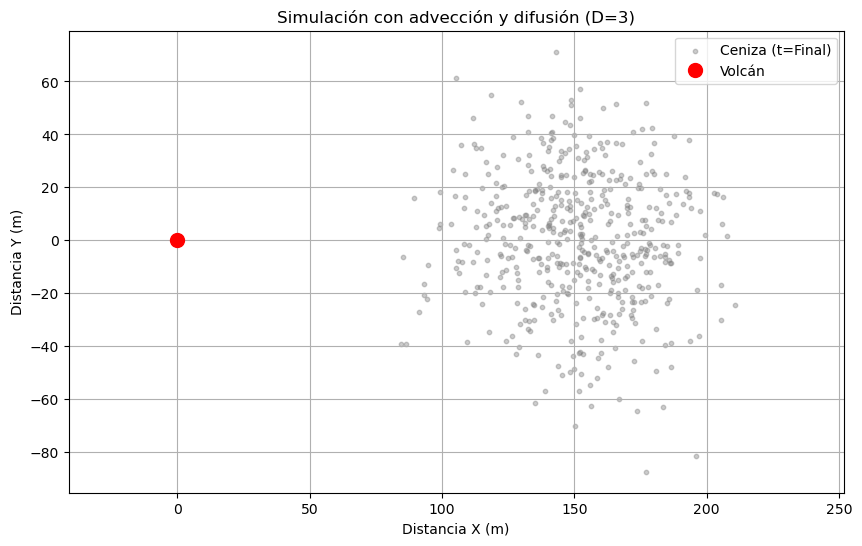

In [7]:

N_PARTICULAS = 500  # Aumentamos para ver una nube densa
DT = 1.0            
TIEMPO_TOTAL = 100  # Más tiempo para ver la expansión
D = 3         # Coeficiente de Difusión (fuerza de la turbulencia)

posiciones = np.zeros((N_PARTICULAS, 2))
viento = np.array([1.5, 0.0]) # Viento hacia la derecha

historial = [posiciones.copy()]

# BUCLE DE SIMULACIÓN 
for t in range(TIEMPO_TOTAL):
    
    # Componente determinista 
    adveccion = viento * DT
    
    # Componente estocástica
    std_dev = np.sqrt(2 * D * DT)
    ruido = np.random.normal(loc=0.0, scale=std_dev, size=(N_PARTICULAS, 2))
    
    # Sumar todo
    posiciones = posiciones + adveccion + ruido
    
    historial.append(posiciones.copy())

# VISUALIZACIÓN
historial = np.array(historial) 

plt.figure(figsize=(10,6))

# Graficamos todas las partículas en el paso final
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], 
            alpha=0.4, s=10, c='gray', label='Ceniza (t=Final)')

# Graficamos el punto de origen
plt.plot(0, 0, 'ro', markersize=10, label='Volcán')

plt.grid(True)
plt.legend()
plt.title(f"Simulación con advección y difusión (D={D})")
plt.xlabel("Distancia X (m)")
plt.ylabel("Distancia Y (m)")
plt.axis('equal') 
plt.show()

## Experimento 3: Viento realista

**Observación Visual:**
La nube se deforma diagonalmente.

**Explicación física:**
En la atmósfera real, el viento no es constante. Implementamos un perfil de cizalladura (Wind Shear), donde la velocidad del viento depende de la altura ($y$):
* Las partículas que (por azar) se difundieron hacia arriba, encontraron vientos más fuertes y avanzaron más rápido.
* Las partículas que bajaron, encontraron vientos más suaves y se quedaron rezagadas.

Este fenómeno es crítico en vulcanología: la dispersión de ceniza depende fuertemente de en qué capa de la atmósfera se encuentre la partícula. 

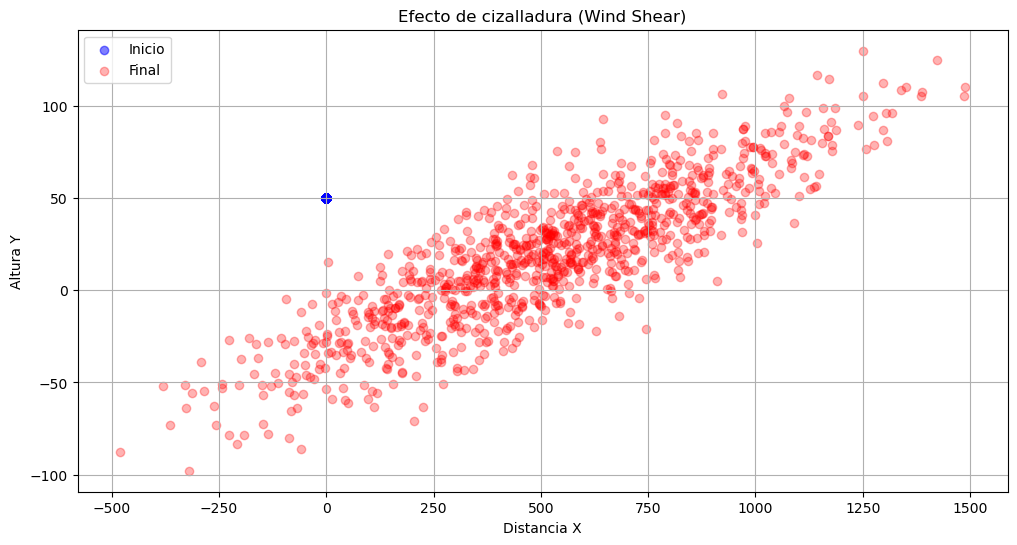

In [8]:
import numpy as np
import matplotlib.pyplot as plt

N_PARTICULAS = 1000
DT = 1.0
TIEMPO_TOTAL = 150
D = 5.0 

# Todas nacen en x=0, y=50 (Altura media para ver cómo el viento varía arriba y abajo)
posiciones = np.zeros((N_PARTICULAS, 2)) + [0.0, 50.0] 
historial = [posiciones.copy()]

# FUNCIÓN DE CAMPO DE VIENTO 
def obtener_viento(posiciones):
    """
    Calcula el vector de viento para cada partícula dependiendo de su altura (y). El viento es más fuerte a mayor altura.
    """
    # Extraemos las alturas (columna 1)
    alturas = posiciones[:, 1]
    
    # Velocidad X: Aumenta con la altura (0.1 * altura)
    vx = 0.1 * alturas 
    
    # Velocidad Y: Supongamos que hay una ligera corriente hacia abajo (gravedad/sedimentación)
    vy = np.full(alturas.shape, -0.2) 
    
    # Apilamos vx y vy para tener la forma (N, 2)
    return np.column_stack((vx, vy))

# BUCLE DE SIMULACIÓN 
for t in range(TIEMPO_TOTAL):
    
    # Calcular el viento local para cada partícula
    viento_local = obtener_viento(posiciones)
    
    # Advección
    adveccion = viento_local * DT
    
    # Difusión (Ruido)
    std_dev = np.sqrt(2 * D * DT)
    ruido = np.random.normal(0, std_dev, size=(N_PARTICULAS, 2))
    
    # Actualizar
    posiciones = posiciones + adveccion + ruido
    historial.append(posiciones.copy())

#  VISUALIZACIÓN
historial = np.array(historial)

plt.figure(figsize=(12,6))

# Graficamos estado inicial (Azul)
plt.scatter(historial[0, :, 0], historial[0, :, 1], c='blue', alpha=0.5, label='Inicio')

# Graficamos estado final (Rojo)
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], c='red', alpha=0.3, label='Final')

plt.title("Efecto de cizalladura (Wind Shear)")
plt.xlabel("Distancia X")
plt.ylabel("Altura Y")
plt.grid(True)
plt.legend()
plt.show()

## Experimento 4: Condiciones de frontera y topografía

**Observación visual:**
Hasta ahora, nuestras partículas caían al vacío infinito (valores negativos de $y$). En esta fase, introducimos un suelo ($y=0$) y una estructura volcánica.
* Las partículas que tocan el suelo se detienen y cambian de color (simulando ceniza fría depositada).
* El punto de emisión ya no flota en la nada, sino que corresponde a la cima de un cono volcánico de 100m de altura.

**Explicación física:**
En física computacional, un sistema de ecuaciones diferenciales necesita condiciones de frontera (Boundary Conditions) para ser resuelto en un espacio finito.
Hemos implementado una frontera absorbente en el suelo:
1.  **Detección de colisión:** En cada paso, verificamos si la posición $y_i \le 0$.
2.  **Sedimentación:** Si hay colisión, anulamos la velocidad de la partícula y fijamos su posición en $y=0$. Físicamente, esto representa la deposición de material piroclástico que deja de ser transportado por el viento.

**Optimización computacional:**
Para mantener la eficiencia, utilizamos **Máscaras Booleanas** de NumPy. Esto nos permite "apagar" los cálculos de física (viento y ruido) para las partículas que ya están en el suelo, ahorrando recursos computacionales a medida que avanza la simulación.

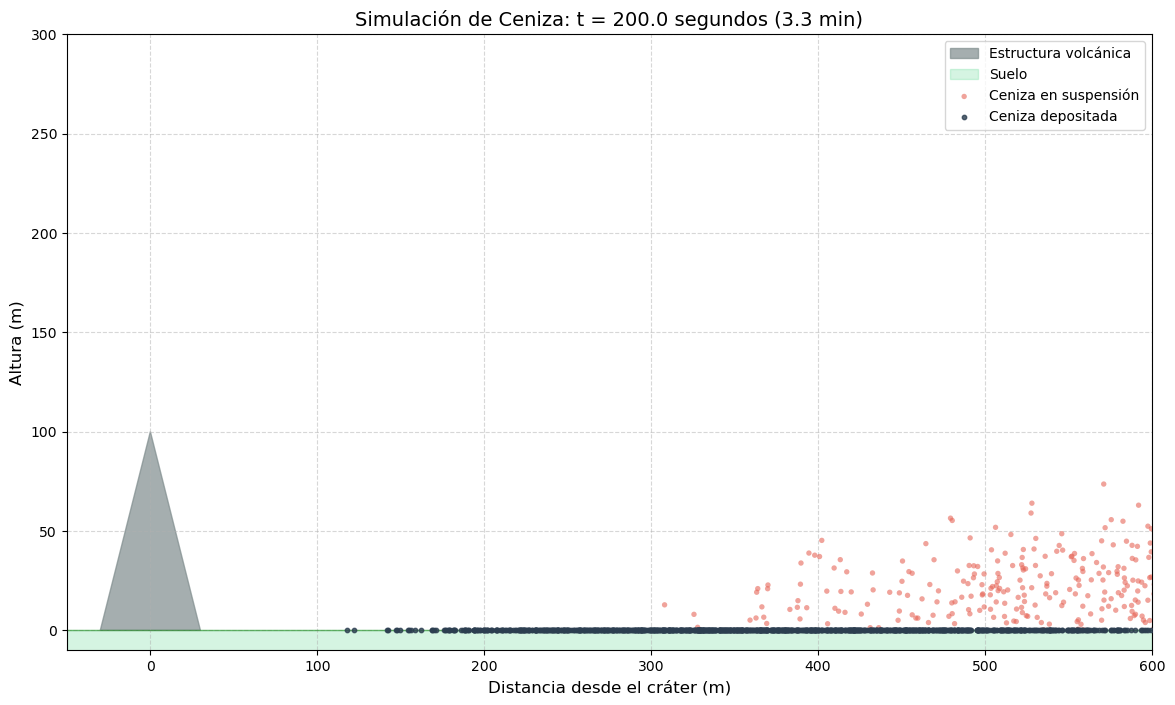

In [9]:
import numpy as np
import matplotlib.pyplot as plt

N_PARTICULAS = 2000
DT = 1.0
TIEMPO_TOTAL = 200
D = 5.0 

posiciones = np.zeros((N_PARTICULAS, 2)) + [0.0, 100.0] # Empiezan a 100m
# Creamos un array para saber quién está en el aire y quién en el suelo
# True = Vuela, False = En el suelo
estado_vuelo = np.ones(N_PARTICULAS, dtype=bool) 

historial = [posiciones.copy()]


def obtener_viento(posiciones):
    alturas = posiciones[:, 1]
    vx = 0.05 * alturas          # Cizalladura
    vy = np.full(alturas.shape, -0.5) # Gravedad/Sedimentación constante hacia abajo
    return np.column_stack((vx, vy))

# BUCLE 
for t in range(TIEMPO_TOTAL):
    
    # Solo actualizamos las partículas que siguen volando (estado_vuelo == True)

    # Filtramos: solo tomamos las posiciones de las partículas en el aire
    pos_activas = posiciones[estado_vuelo]
    
    if len(pos_activas) > 0: # Solo calculamos si queda alguna volando
        viento = obtener_viento(pos_activas)
        adveccion = viento * DT
        
        std_dev = np.sqrt(2 * D * DT)
        ruido = np.random.normal(0, std_dev, size=pos_activas.shape)
        
        # Mover solo las activas
        posiciones[estado_vuelo] += adveccion + ruido
    
    # CONDICIÓN DE SUELO 
    # Revisamos quiénes han cruzado el suelo (y <= 0) en este paso
    en_suelo = posiciones[:, 1] <= 0
    
    # A las que tocaron suelo, corregimos su posición a 0 
    posiciones[en_suelo, 1] = 0.0
    
    # Cambiamos el estado de vuelo de esas particulas para que el IF de arriba las ignore en el futuro
    estado_vuelo[en_suelo] = False
    
    historial.append(posiciones.copy())

# VISUALIZACIÓN 
historial = np.array(historial)


plt.figure(figsize=(14, 8))
ax = plt.gca() # Obtenemos el eje actual para dibujar formas

# DIBUJAR EL VOLCÁN (Contexto visual)
altura_volcan = 100
ancho_base = 60
volcan_x = [-ancho_base/2, 0, ancho_base/2]
volcan_y = [0, altura_volcan, 0]
ax.fill(volcan_x, volcan_y, color='#7f8c8d', alpha=0.7, label='Estructura volcánica', zorder=1)

# DIBUJAR EL SUELO
plt.axhspan(-20, 0, color='#2ecc71', alpha=0.2, label='Suelo', zorder=0)
plt.axhline(0, color='green', linewidth=1, alpha=0.5)

# DIBUJAR LAS PARTÍCULAS
final_x = historial[-1, :, 0]
final_y = historial[-1, :, 1]

# Identificamos cuáles vuelan y cuáles cayeron
vivas = final_y > 0

# Partículas en el aire (Rojo/Naranja volcánico)
plt.scatter(final_x[vivas], final_y[vivas], 
            c="#e66658", s=15, alpha=0.6, edgecolors='none', label='Ceniza en suspensión', zorder=3)

# Partículas en el suelo (Gris oscuro / Ceniza fría)
plt.scatter(final_x[~vivas], final_y[~vivas], 
            c='#2c3e50', s=10, alpha=0.8, label='Ceniza depositada', zorder=3)

# TEXTOS Y DETALLES
tiempo_total_segundos = TIEMPO_TOTAL * DT
plt.title(f"Simulación de Ceniza: t = {tiempo_total_segundos} segundos ({tiempo_total_segundos/60:.1f} min)", fontsize=14)
plt.xlabel("Distancia desde el cráter (m)", fontsize=12)
plt.ylabel("Altura (m)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)


plt.xlim(-50, 600)
plt.ylim(-10, 300)

plt.show()

## Experimento 5: Simulación de pluma continua (Emisión temporal)

**Observación visual:**
Transformamos la explosión instantánea en una erupción continua. Observamos la formación de una "Pluma volcánica": una columna de partículas que emerge constantemente del cráter, es curvada por el viento y genera un patrón de deposición sostenido en el suelo.

**Lógica de implementación (Vectorización temporal):**
En lugar de añadir partículas al array dinámicamente (lo cual es lento), pre-asignamos todas las partículas en memoria pero diferimos su activación.
* Asignamos a cada partícula un tiempo de nacimiento $t_{nac}$.
* En cada paso de tiempo $t$, aplicamos la ecuación de movimiento solo a las partículas donde $t \ge t_{nac}$.
Esto simula un flujo de masa constante ($\dot{m}$) saliendo del vent.

**Resultado físico:**
Este modelo captura la naturaleza dinámica de la ceniza. Podemos observar regiones de alta densidad cerca de la fuente y cómo la dispersión (difusión) diluye la nube a medida que viaja a favor del viento ("downwind").

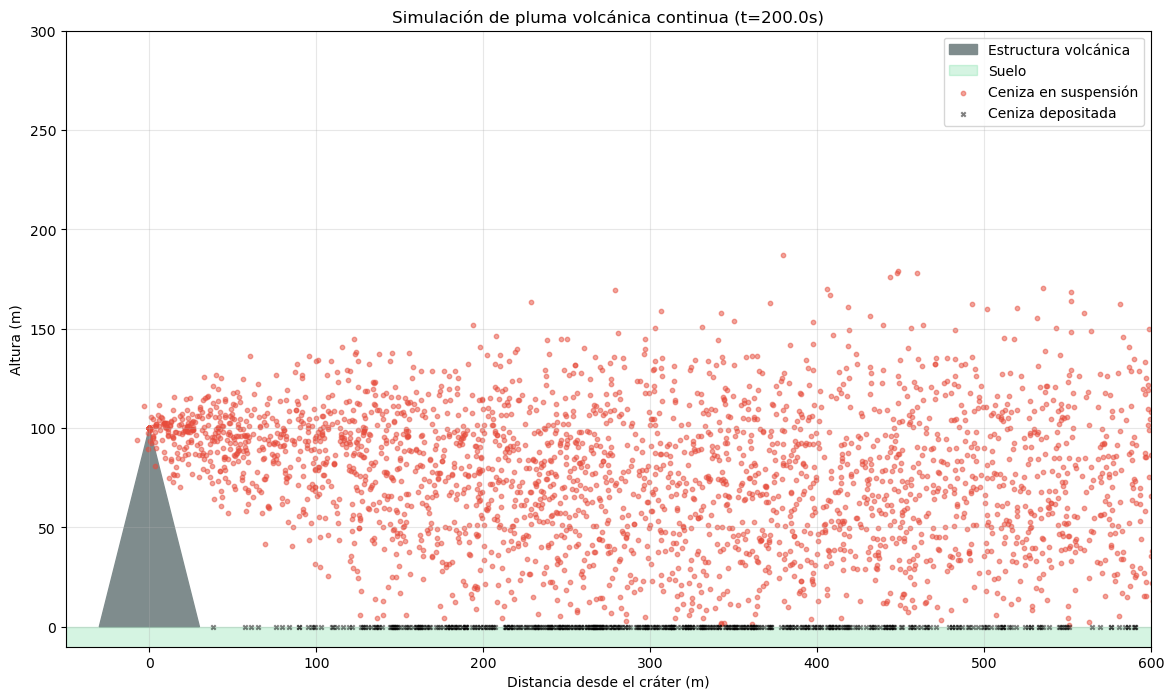

In [10]:
import numpy as np
import matplotlib.pyplot as plt

N_PARTICULAS = 4000      # Más partículas para que la emisión dure mas
DT = 1.0                 # Paso de tiempo 
TIEMPO_TOTAL = 200       # Duración total de la simulación
D = 10.0                 # Difusión 

# Datos del volcán
ALTURA_VOLCAN = 100.0
POS_VOLCAN = [0.0, ALTURA_VOLCAN]


# Posiciones: Todas nacen en la boca del volcán
posiciones = np.zeros((N_PARTICULAS, 2)) + POS_VOLCAN

# Tiempos de nacimiento:
# Repartimos las salidas de las partículas a lo largo del tiempo
# Las partículas con t_nacimiento > t_actual se quedarán "esperando" en el volcán.
tiempos_nacimiento = np.linspace(0, 200, N_PARTICULAS)

# EstadoÑ
# Al principio inguna vuela hasta que nazca, pero usaremos esta máscara
# para apagar las que toquen el suelo.
en_suelo = np.zeros(N_PARTICULAS, dtype=bool) # False = No ha tocado suelo

historial = []

def obtener_viento(pos_array):
    """Viento con cizalladura: Más fuerte arriba."""
    alturas = pos_array[:, 1]
    
    # Viento horizontal: Aumenta con la altura
    vx = 0.05 * alturas 
    
    # Viento vertical: Ligera gravedad/caída constante
    vy = np.full(alturas.shape, -0.3) 
    
    return np.column_stack((vx, vy))

# BUCLE DE SIMULACIÓN
for t_step in range(TIEMPO_TOTAL):
    tiempo_actual = t_step * DT
    
    # Una partícula se mueve SI Y SOLO SI:
    # 1. Ya nació (tiempo_actual >= tiempo_nacimiento)
    # 2. No ha tocado el suelo (en_suelo == False)
    
    ya_nacieron = tiempos_nacimiento <= tiempo_actual
    activas = ya_nacieron & (~en_suelo) 
    
    # Si no hay nadie volando, saltamos al siguiente paso
    if np.sum(activas) == 0:
        continue
    #Para las activas:   
    pos_activas = posiciones[activas]
    
    # Advección
    viento = obtener_viento(pos_activas)
    # Difusión
    ruido = np.random.normal(0, np.sqrt(2 * D * DT), size=pos_activas.shape)
    # Actualizar
    posiciones[activas] += (viento * DT) + ruido
    
    # Condiciones de frontera
    # Revisamos solo las que estaban activas, si cruzaron y <= 0
    nuevos_choques = (posiciones[:, 1] <= 0) & activas
    
    # Corregimos posición y marcamos como suelo
    posiciones[nuevos_choques, 1] = 0.0
    en_suelo[nuevos_choques] = True
    
    historial.append(posiciones.copy())


# VISUALIZACIÓN
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Dibujar volcán
ax.fill([-30, 0, 30], [0, ALTURA_VOLCAN, 0], color='#7f8c8d',label= "Estructura volcánica", zorder=1)

# 2. Dibujar suelo
plt.axhspan(-20, 0, color='#2ecc71',label="Suelo", alpha=0.2)

# 3. Dibujar partículas
# - Las que AÚN NO NACEN siguen en el cráter (las ignoramos o pintamos transparentes)
# - Las que VUELAN (Rojas)
# - Las del SUELO (Negras)

mask_volando = (tiempos_nacimiento <= (TIEMPO_TOTAL*DT)) & (~en_suelo)
mask_suelo = en_suelo

plt.scatter(posiciones[mask_volando, 0], posiciones[mask_volando, 1], 
            c='#e74c3c', s=10, alpha=0.5, label='Ceniza en suspensión')

plt.scatter(posiciones[mask_suelo, 0], posiciones[mask_suelo, 1], 
            c='black', s=10, alpha=0.5, marker='x', label='Ceniza depositada')

plt.title(f"Simulación de pluma volcánica continua (t={TIEMPO_TOTAL*DT}s)")
plt.xlabel("Distancia desde el cráter (m)")
plt.ylabel("Altura (m)")
plt.legend()
plt.xlim(-50, 600)
plt.ylim(-10, 300)
plt.grid(True, alpha=0.3)
plt.show()